# Modeling TF-IDF + MLP (Multi Layer Perceptron) Notebook

**Based on the developed pipeline in `template_logreg_tfidf.ipynb`**

We rely on Galke et al. 2022 for the specific WideMLP Setup

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    fbeta_score,
    make_scorer
)
from joblib import dump, load
from scipy.stats import loguniform, randint

root_path = Path.cwd().parents[1]  #go to root
sys.path.append(str(root_path))
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    extended_classification_report,
    get_metrics_dict,
    quick_f2_score_default_threshold
)
from src.widemlp_skorch import ToFloat32Dense,make_widemlp_skorch # our skorch widemlp setup
from src.preprocessing import process_file
from src.optimize_threshold import (
    optimize_threshold_with_cv,
    get_threshold_evaluation_data,
    get_threshold_evaluation_data_cv
)
from src.optuna_optimizer import (
    optimize_with_optuna_tpe,
    sample_class_weight_value,
    grid_search_with_optuna
)
from src.optuna_visualizations import (
    plot_optuna_study_analysis,
    quick_optuna_analysis
)

from src.phrase_transformer import PhraseDetector

c:\Users\tdoro\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

print("Torch-Version:", torch.__version__)
print("CUDA-Toolchain in Torch:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU-Name:", torch.cuda.get_device_name(0))

#test
x = torch.randn(5000, 5000, device="cuda")
y = torch.matmul(x, x)
print("Device:", y.device)


Torch-Version: 2.5.1
CUDA-Toolchain in Torch: 12.4
CUDA available: True
GPU-Name: NVIDIA GeForce RTX 4050 Laptop GPU
Device: cuda:0


**a) MLPClassifier with basic preprocessed data**

In [2]:
# Load and preprocess data (basic mode)
df_basiccleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

MLP TPE basic

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Best parameters found by Optuna TPE: {'clf__lr': 0.001010664427248916, 'clf__batch_size': 16, 'clf__module__hidden_dim': 768, 'clf__module__dropout_p': 0.6541183374194437, 'clf__optimizer__weight_decay': 4.547817384823113e-06, 'mlp_pos_weight': 10.600046445953542, 'clf__criterion__label_smoothing': 0.024539583035764746, 'select__k': 194}
Best F2 score during optimization: 0.825

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


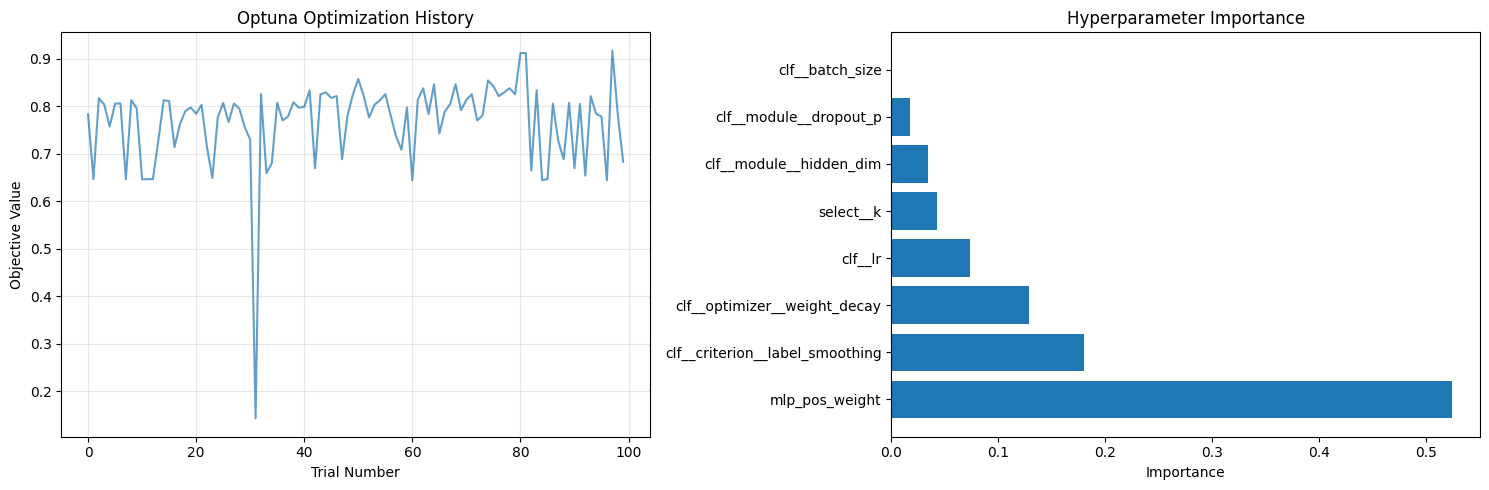


2. Parameter Value Distributions:


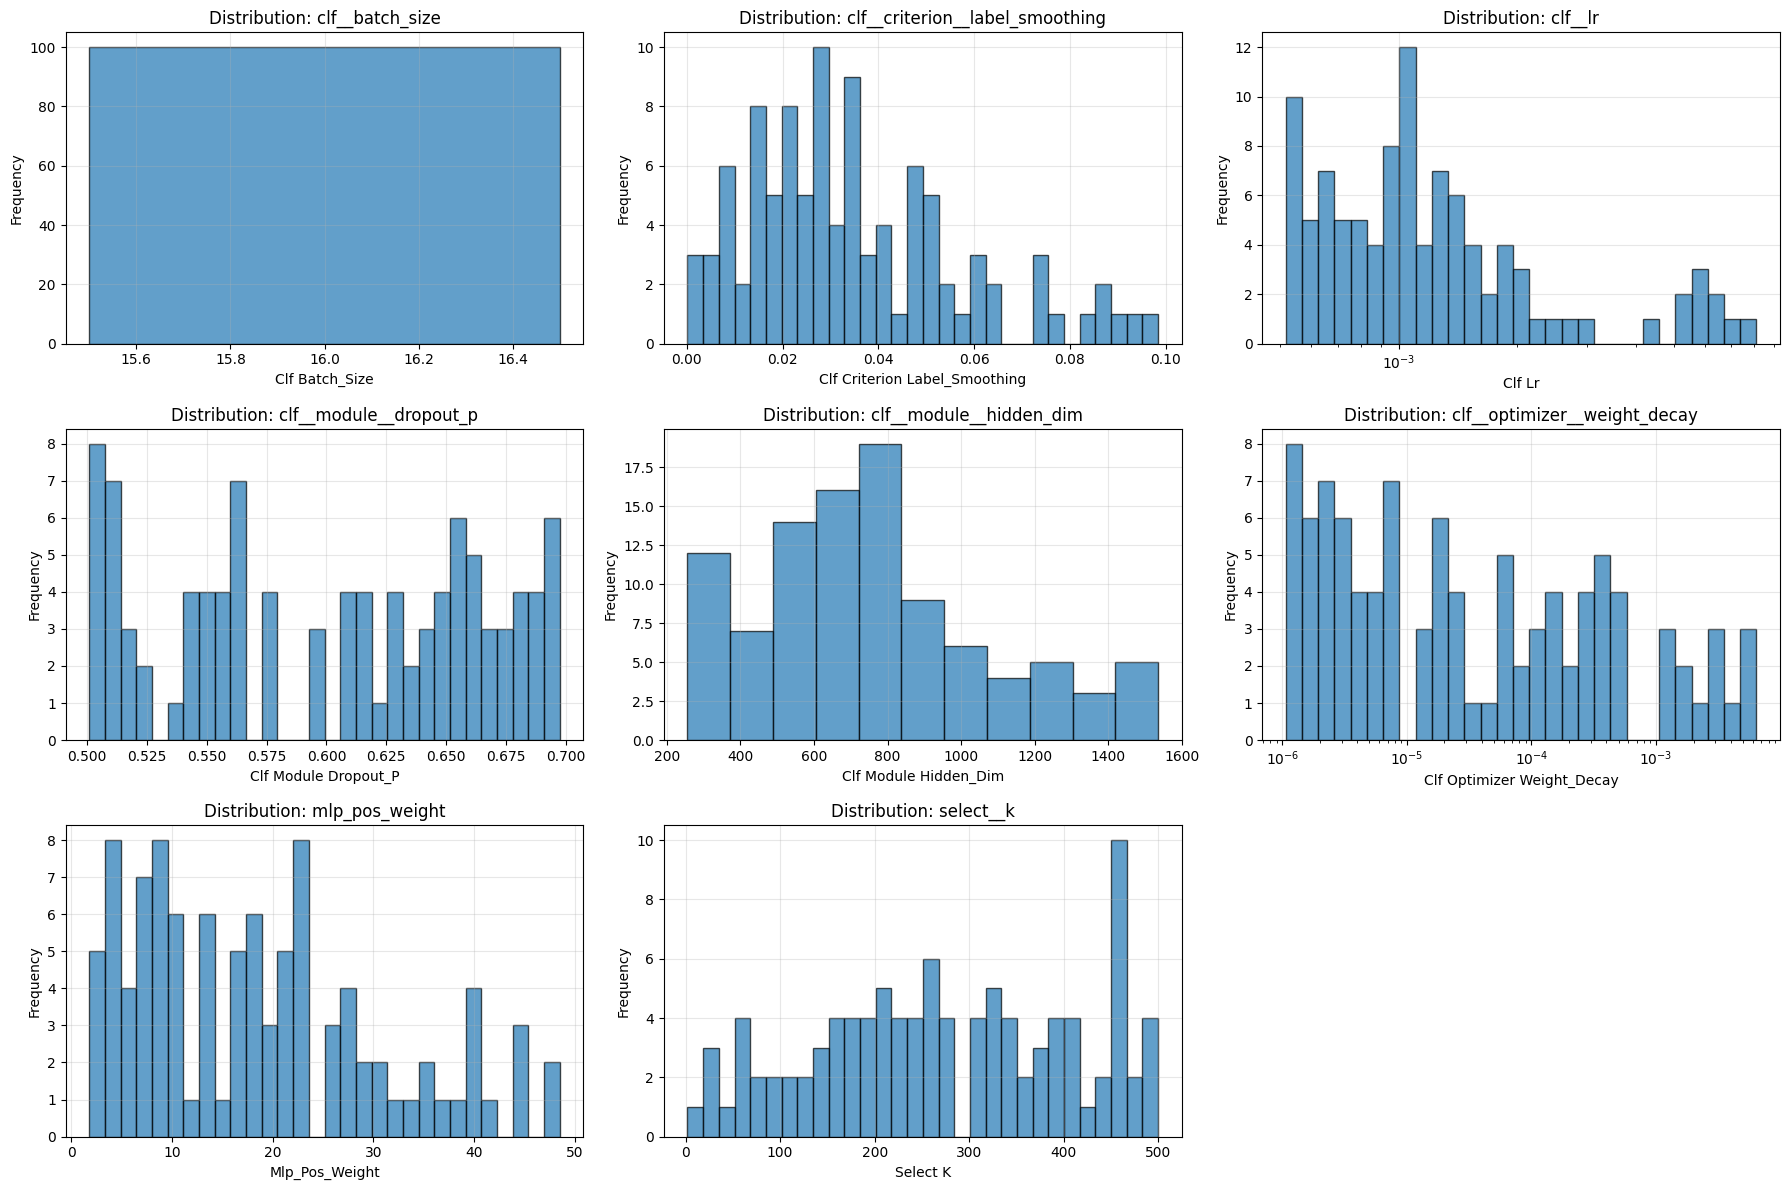


3. Performance vs Individual Parameters:


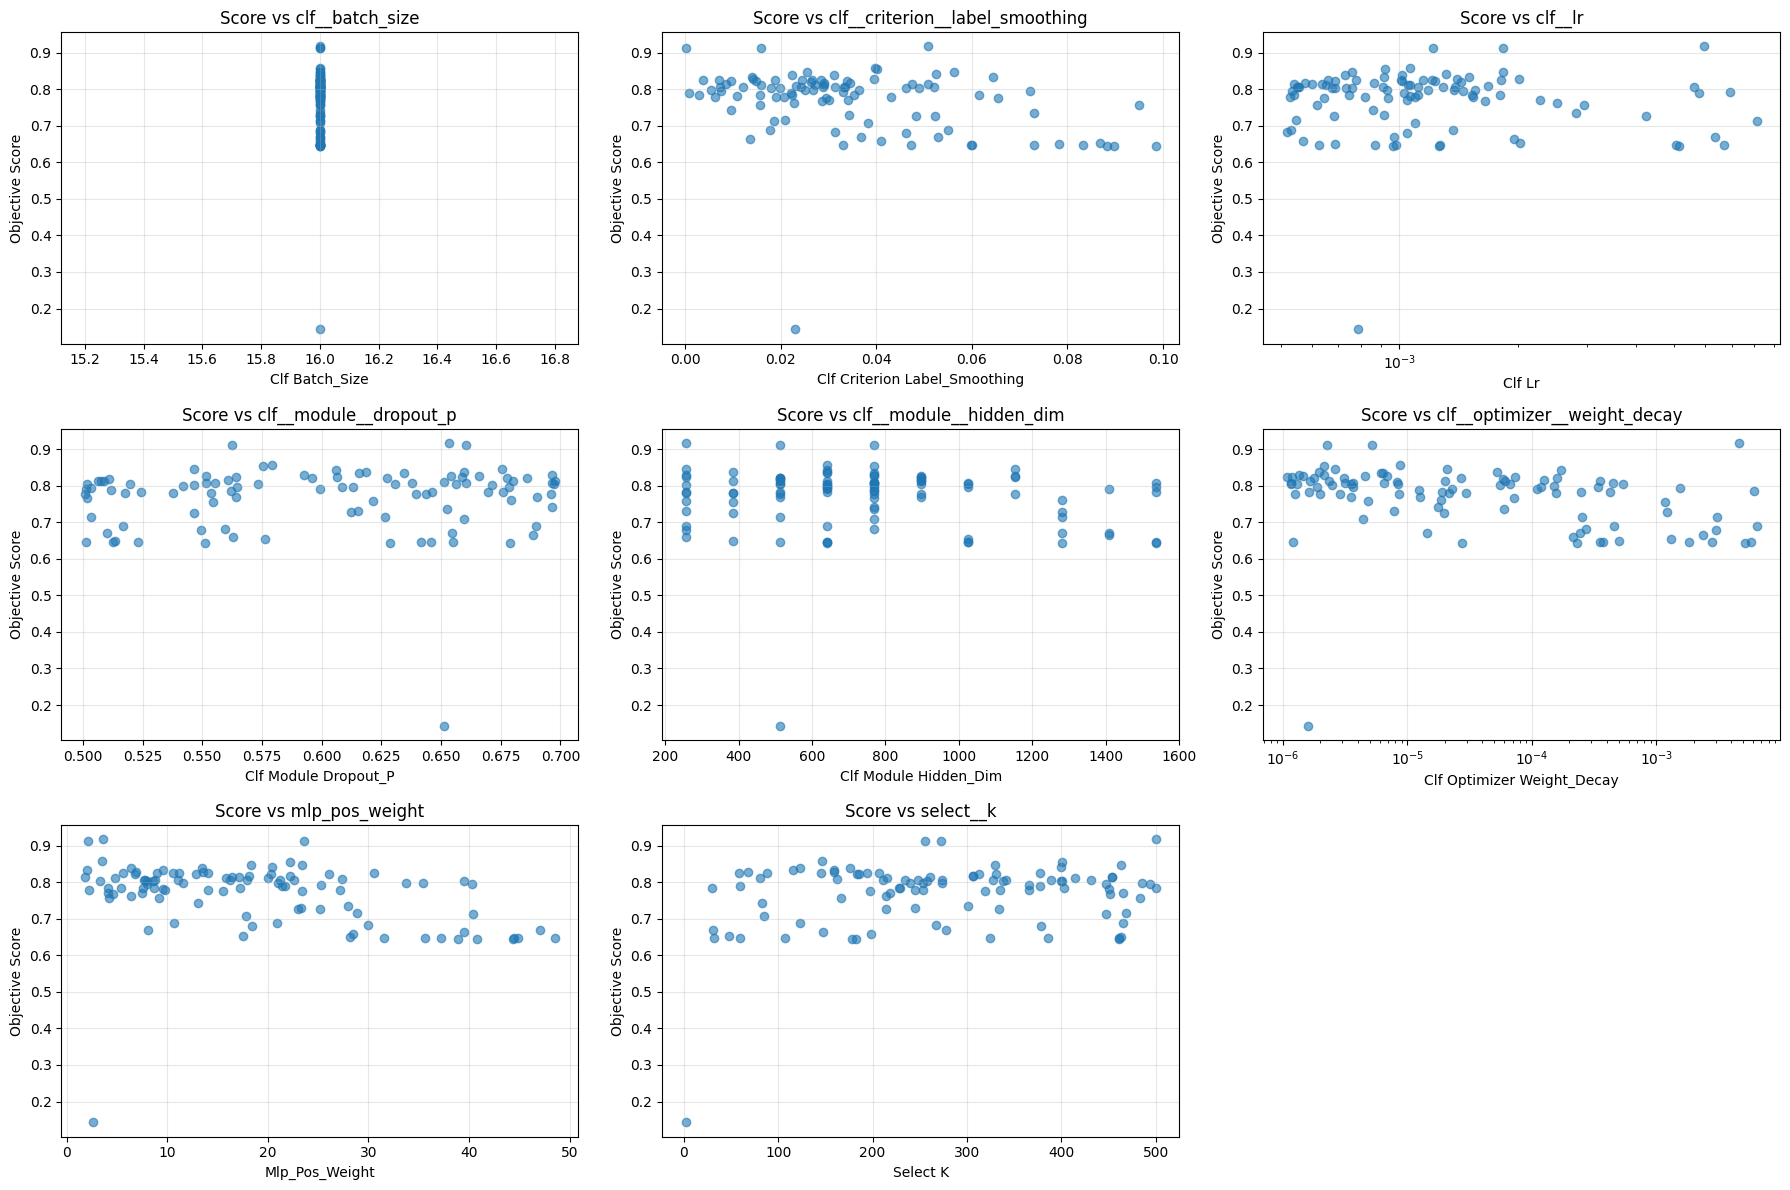


4. Convergence Analysis:


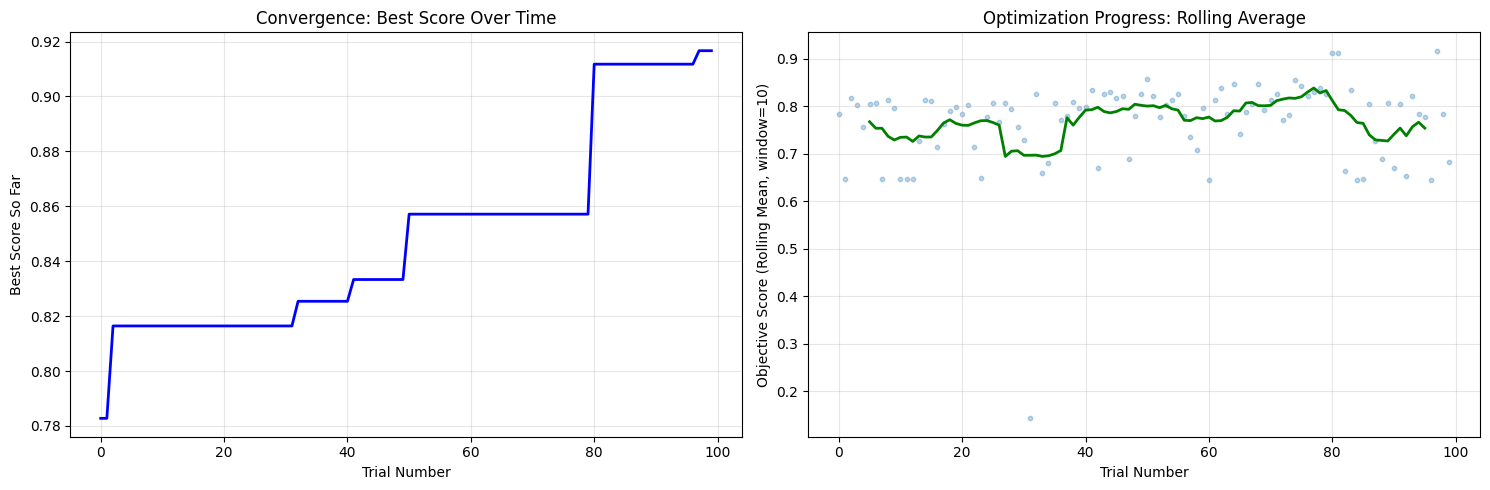


5. Trial Status Overview:


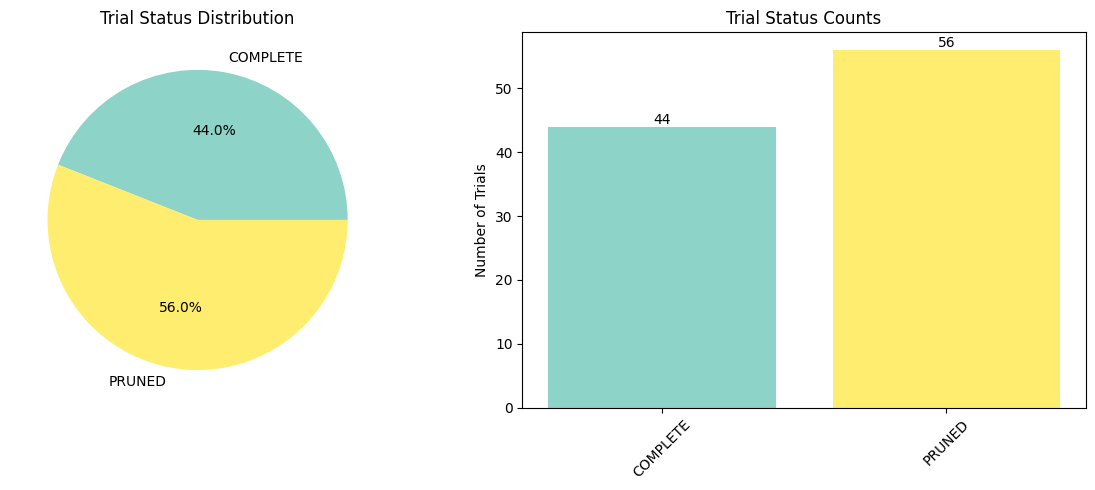


6. Top 10 Best Trials:
Rank Trial#  Score      batch_size   label_smoothing lr           dropout_p    hidden_dim   weight_decay mlp_pos_weight k           
------------------------------------------------------------------------------------------------------------------------------------
1    32      0.8254     16           0.0245       0.0010       0.6541       768          0.0000       10.6000      194         
2    76      0.8210     16           0.0097       0.0012       0.6275       512          0.0000       6.8394       184         
3    2       0.8164     16           0.0291       0.0009       0.5608       512          0.0001       22.1653      306         
4    14      0.8128     16           0.0509       0.0005       0.5063       384          0.0004       16.4034      454         
5    54      0.8125     16           0.0158       0.0011       0.6802       896          0.0000       15.8604      215         
6    8       0.8124     16           0.0271       0.0007       0.5090 

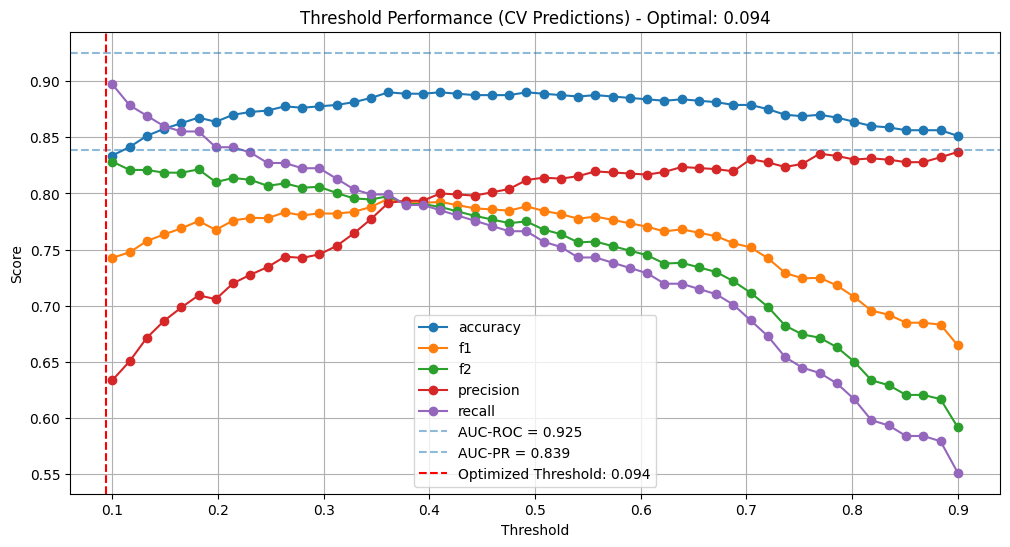

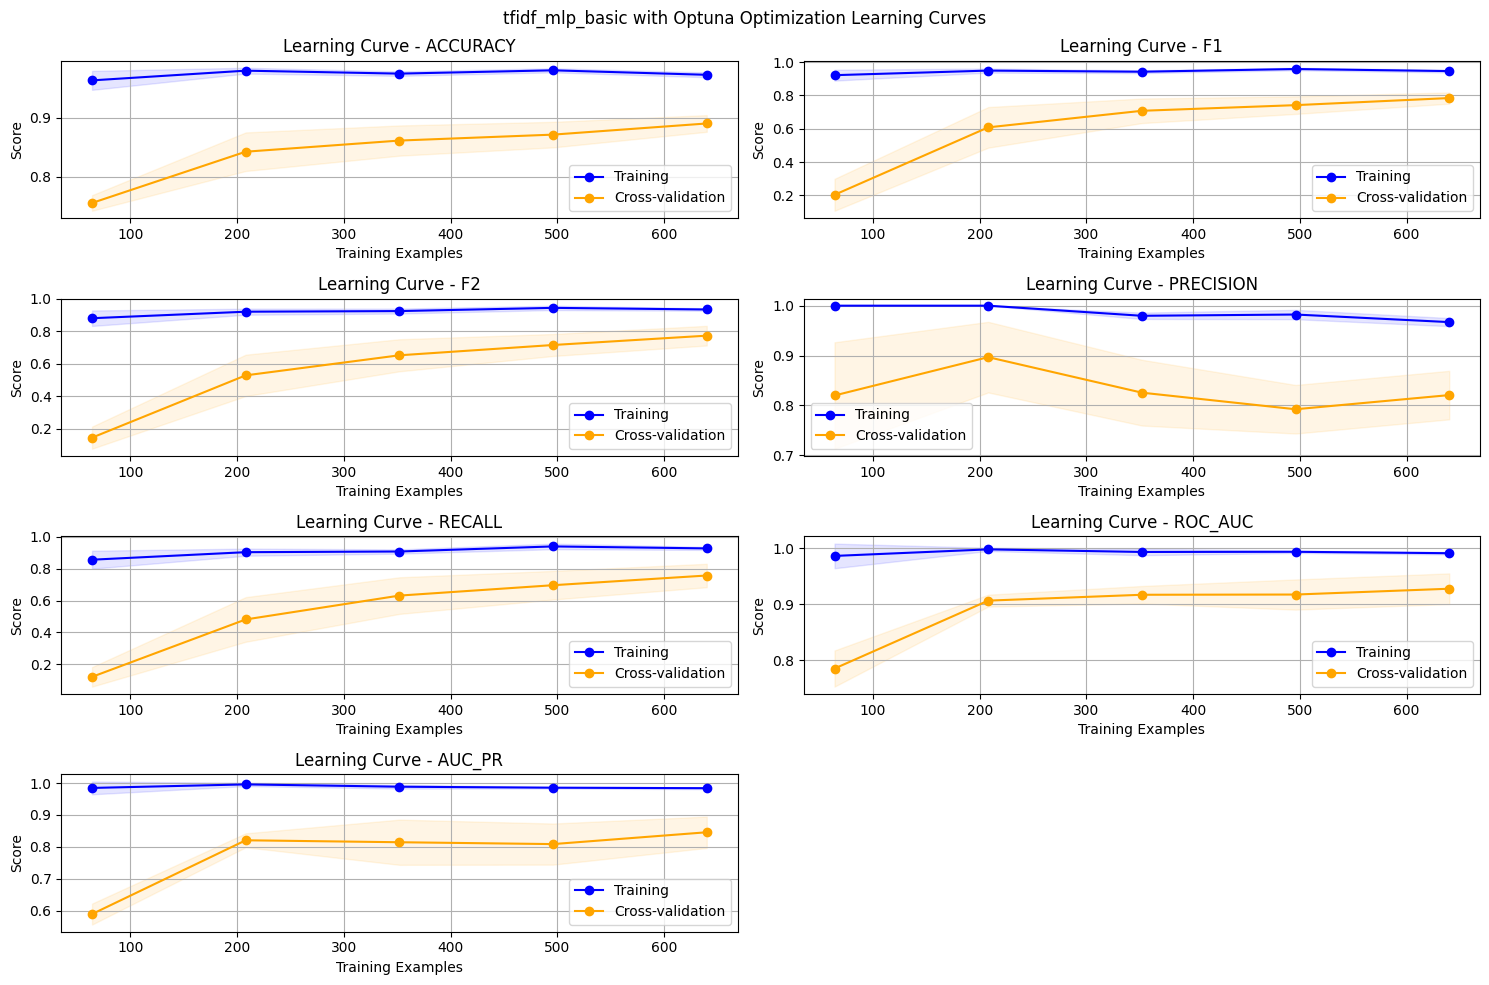


Final Threshold: 0.09

Test Set Performance:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       146
           1       0.64      0.87      0.74        54

    accuracy                           0.83       200
   macro avg       0.79      0.85      0.81       200
weighted avg       0.86      0.83      0.84       200

Additional Metrics:
Accuracy   0.835
F2-score   0.813
AUC-ROC    0.918
AUC-PR     0.807



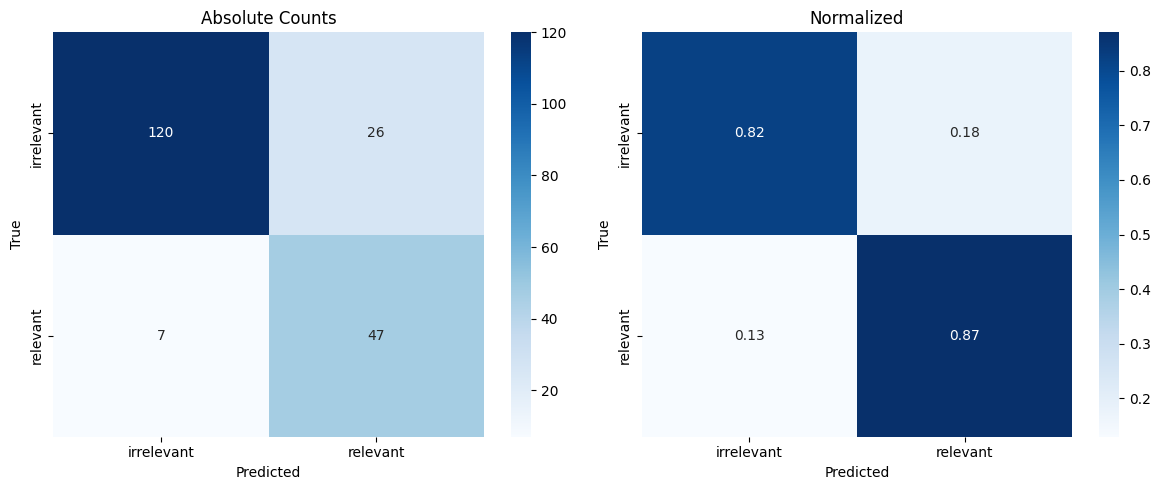

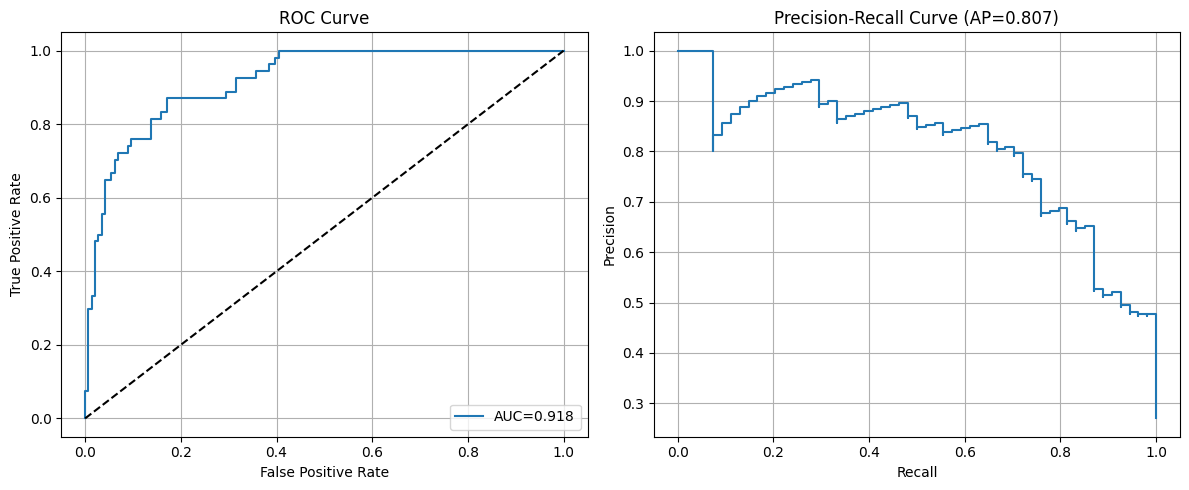


Model saved as model_tfidf_mlp_basic.joblib


In [3]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

pipeline_tfidf_mlp = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("to32",    ToFloat32Dense()), #important for dense vectors
    ("clf",     make_widemlp_skorch( #defaults as in Galke et al. 2022, optimizer, criterion set in widemlp_skorch.py, optimized by optuna tpe
                max_epochs=100, 
                lr=1e-3, 
                batch_size=16, 
                hidden_dim=1024, 
                dropout_p=0.5,
                random_state=42, 
                force_cuda=True  # use GPU
    )),
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    "clf__lr": lambda t: t.suggest_float("clf__lr", 5e-4, 1e-2, log=True),  # Adam LR around 1e-3 
    "clf__batch_size": lambda t: t.suggest_categorical("clf__batch_size", [16]),  # small batches per paper; 32 as speed option
    "clf__module__hidden_dim": lambda t: t.suggest_int("clf__module__hidden_dim", 256, 1536, step=128),  # structured width search around 1024
    "clf__module__dropout_p": lambda t: t.suggest_float("clf__module__dropout_p", 0.5, 0.7),  # focus around 0.5 as optimum per paper
    "clf__optimizer__weight_decay": lambda t: t.suggest_float("clf__optimizer__weight_decay", 1e-6, 1e-2, log=True),  # tiny L2 for stability
    "clf__criterion__weight": lambda t: torch.tensor([1.0, t.suggest_float("mlp_pos_weight", 1.0, 50.0)], dtype=torch.float32, device="cuda"),  # class weight for positives, force GPU
    "clf__criterion__label_smoothing": lambda t: t.suggest_float("clf__criterion__label_smoothing", 0.0, 0.1), #add some regularization
    "select__k": lambda t: t.suggest_int("select__k", 1, 500),  # chi² filter
}



model_name = "tfidf_mlp_basic"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_tfidf_mlp,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "mlp",
    n_trials=100,  # Intelligent search with early stopping
    n_startup_trials=20, # less aggressive prunning
    n_warmup_steps=15,  # first 15 epochs not pruned
    intervall_steps=1, # prunning possible for every epoch
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")



MLP GridSearch basic

Starting Optuna hyperparameter optimization ...
Best parameters found by Optuna TPE: {'clf__lr': 0.001, 'clf__module__hidden_dim': 1024, 'clf__module__dropout_p': 0.5, 'clf__optimizer__weight_decay': 4.548e-06, 'clf__batch_size': 16, 'clf__criterion__label_smoothing': 0.025, 'mlp_pos_weight': 20.0, 'select__k': 175}
Best F2 score during optimization: 0.833

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


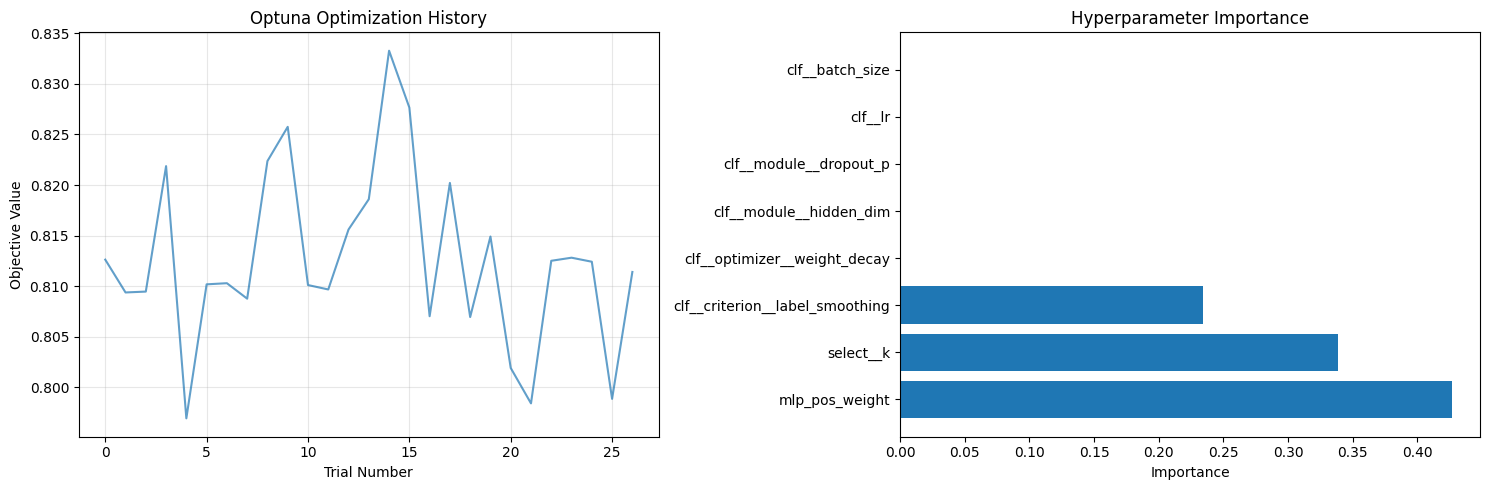


2. Parameter Value Distributions:


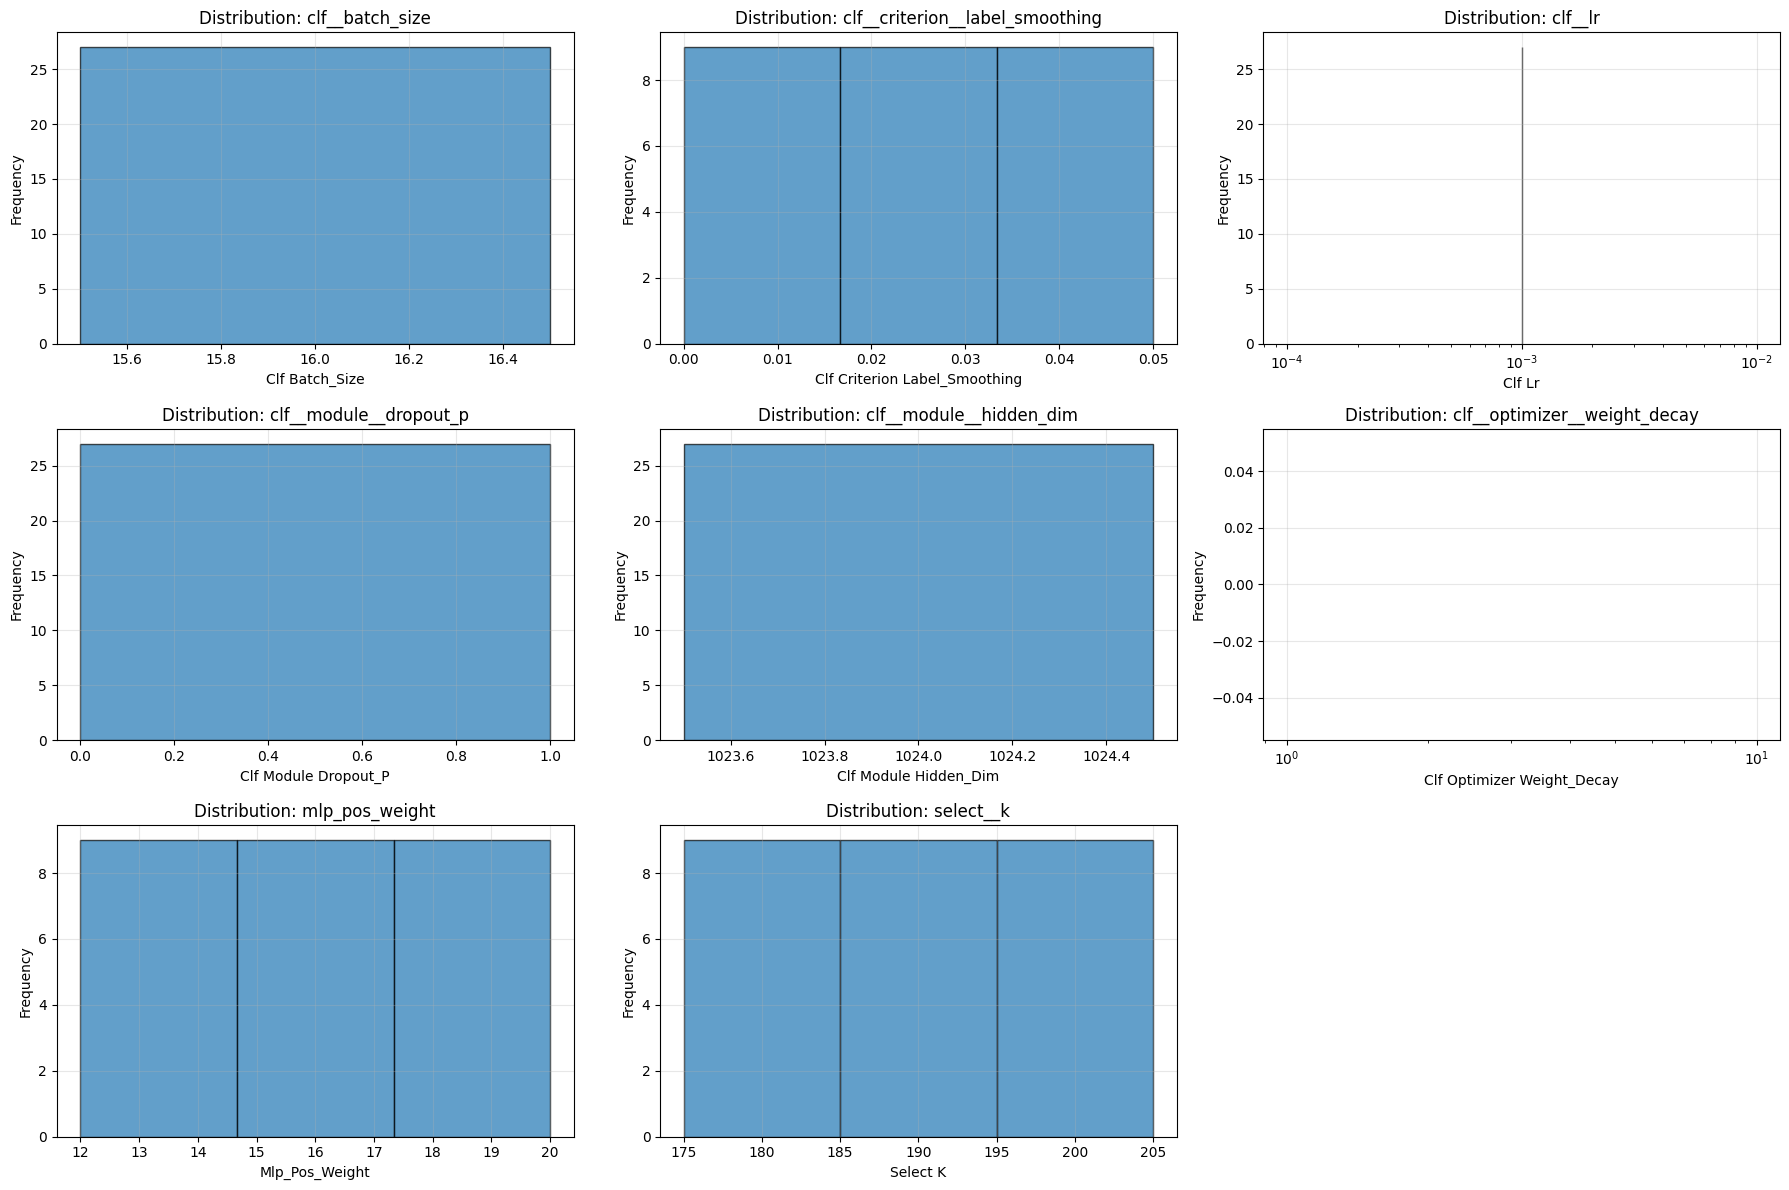


3. Performance vs Individual Parameters:


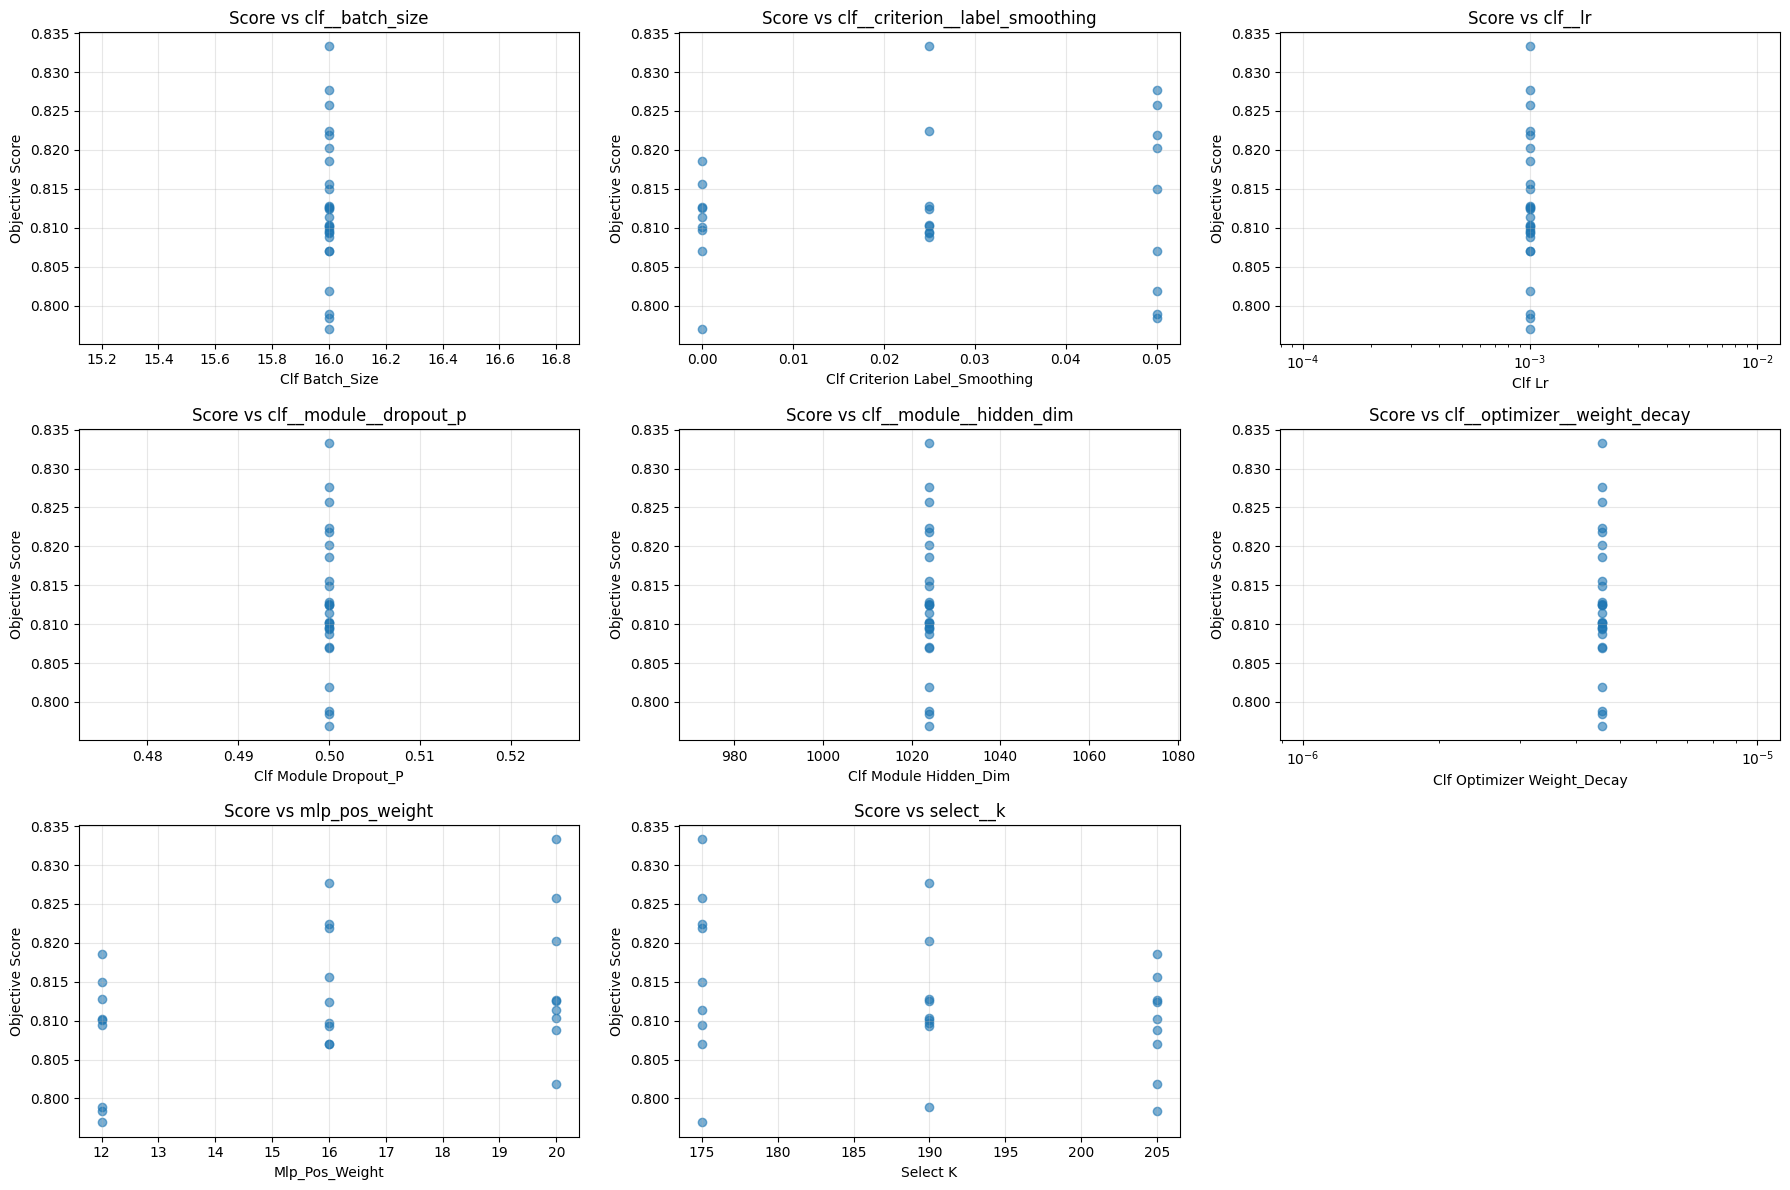


4. Convergence Analysis:


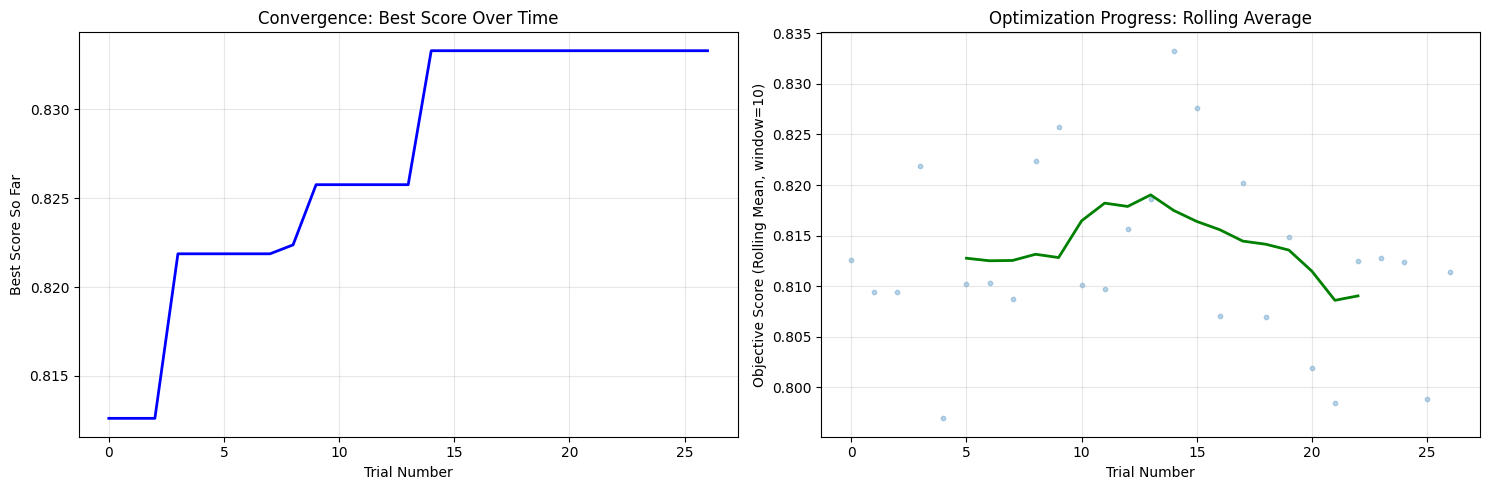


5. Trial Status Overview:


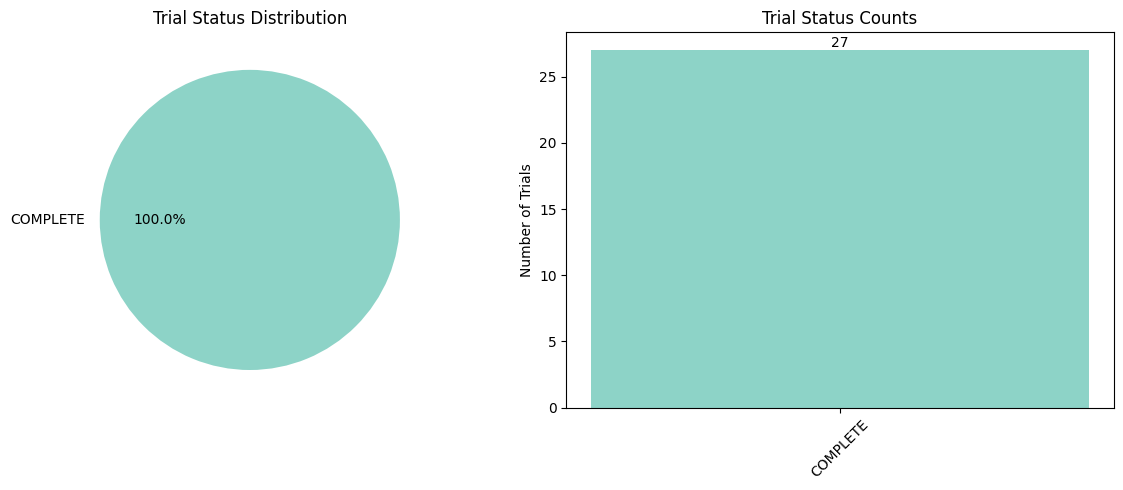


6. Top 10 Best Trials:
Rank Trial#  Score      batch_size   label_smoothing lr           dropout_p    hidden_dim   weight_decay mlp_pos_weight k           
------------------------------------------------------------------------------------------------------------------------------------
1    14      0.8333     16           0.0250       0.0010       0.5000       1024         0.0000       20.0000      175         
2    15      0.8277     16           0.0500       0.0010       0.5000       1024         0.0000       16.0000      190         
3    9       0.8258     16           0.0500       0.0010       0.5000       1024         0.0000       20.0000      175         
4    8       0.8224     16           0.0250       0.0010       0.5000       1024         0.0000       16.0000      175         
5    3       0.8219     16           0.0500       0.0010       0.5000       1024         0.0000       16.0000      175         
6    17      0.8202     16           0.0500       0.0010       0.5000 

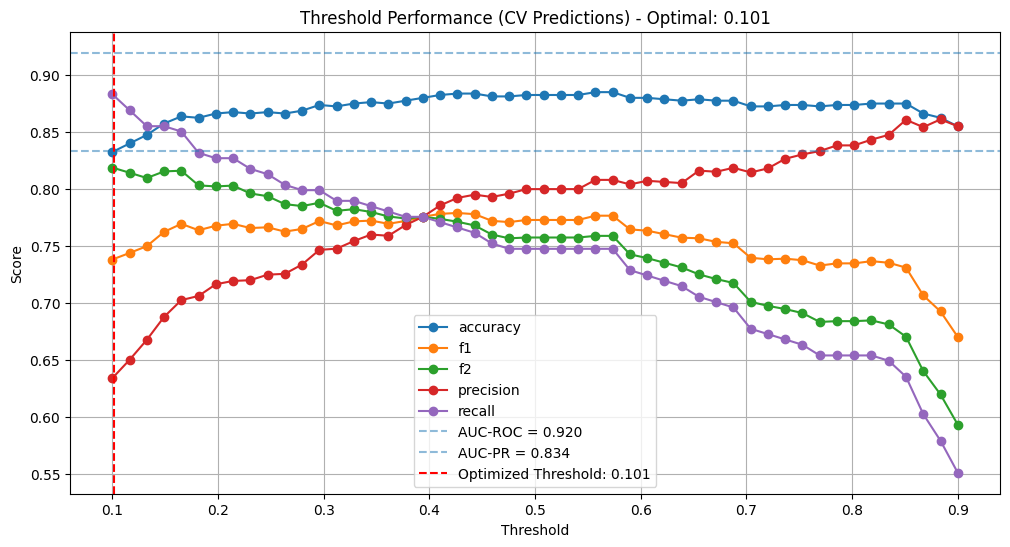

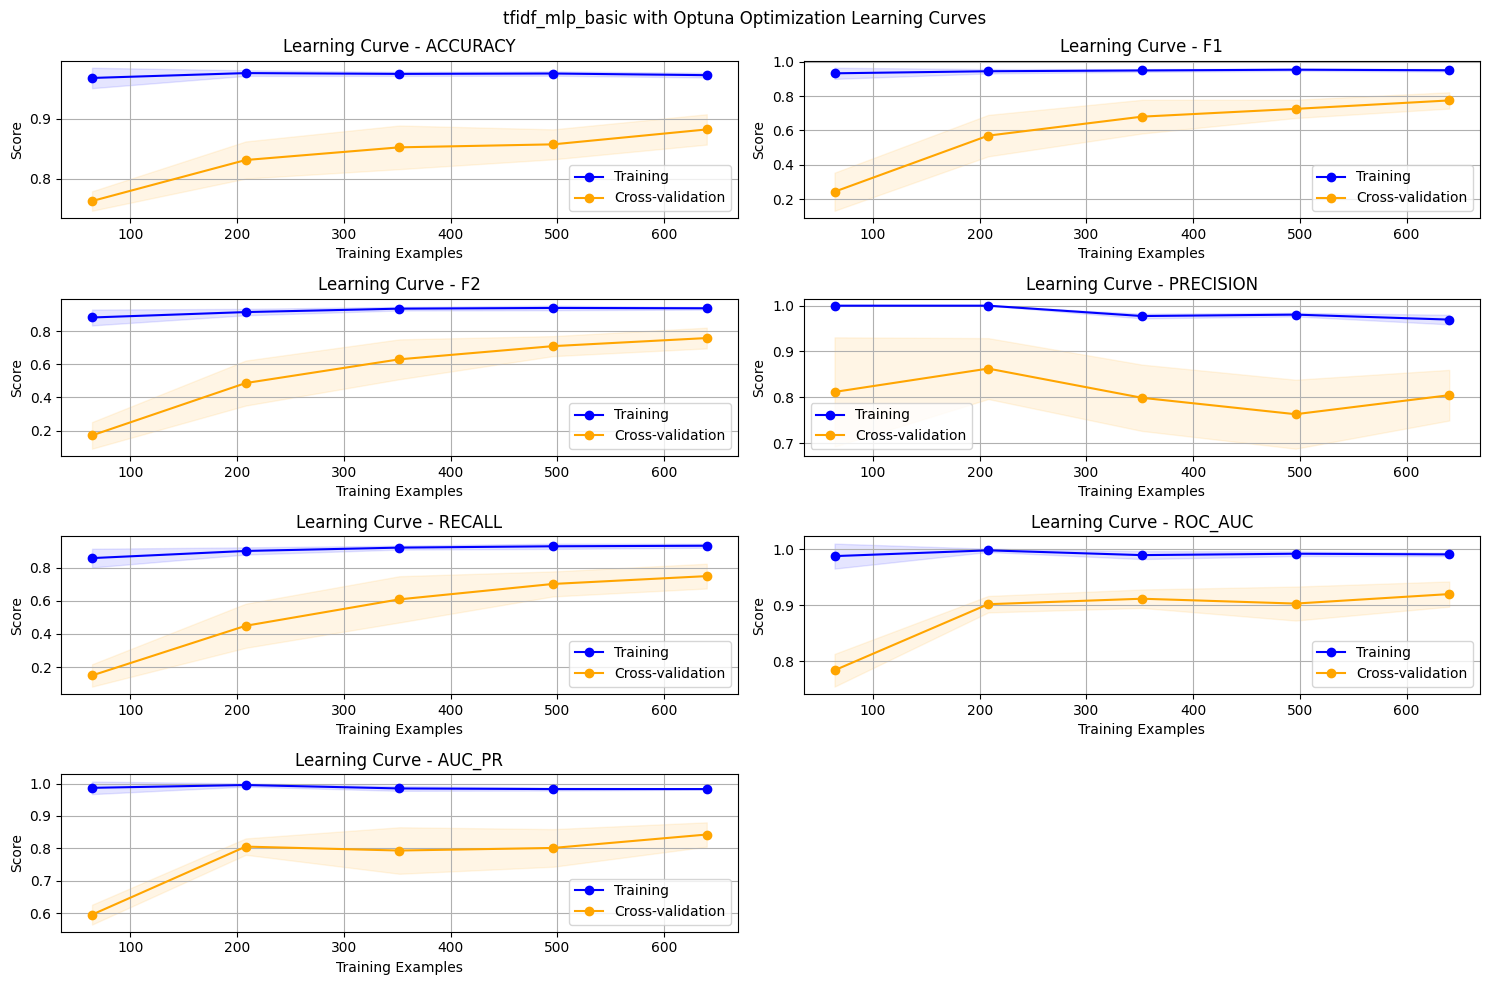


Final Threshold: 0.10
F2-score with default threshold (0.5): 0.690

Test Set Performance:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       146
           1       0.67      0.85      0.75        54

    accuracy                           0.84       200
   macro avg       0.80      0.85      0.82       200
weighted avg       0.87      0.84      0.85       200

Additional Metrics:
Accuracy   0.845
F2-score   0.807
AUC-ROC    0.900
AUC-PR     0.793



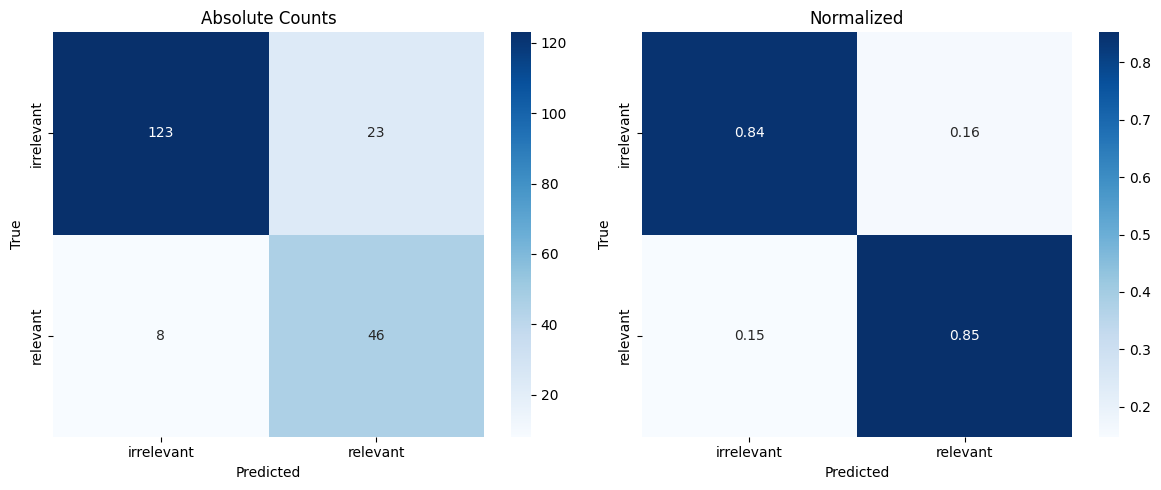

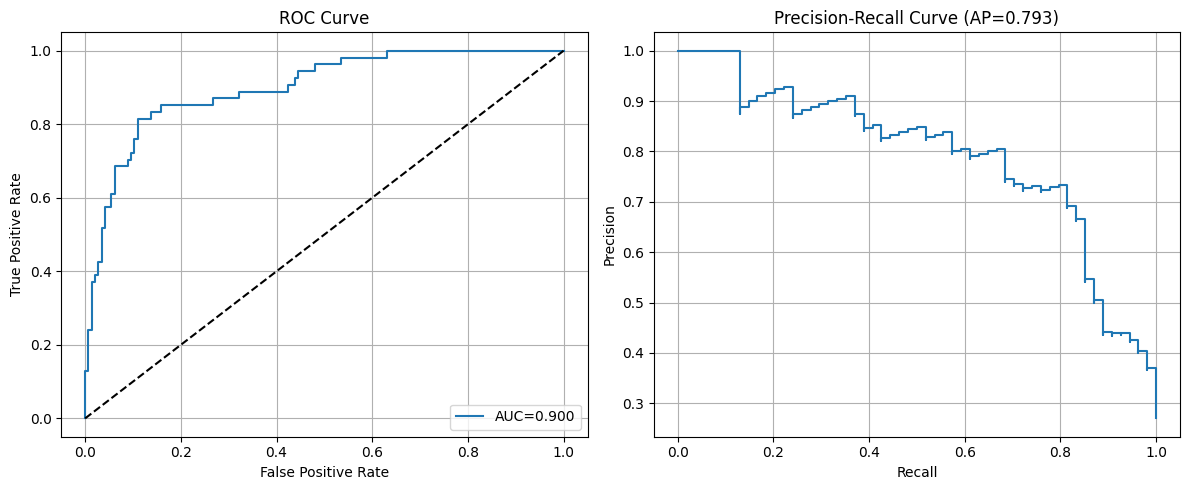


Model saved as model_tfidf_mlp_basic.joblib


In [6]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

pipeline_tfidf_mlp = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("to32",    ToFloat32Dense()), #important for dense vectors
    ("clf",     make_widemlp_skorch( #defaults as in Galke et al. 2022, optimizer, criterion set in widemlp_skorch.py, optimized by optuna tpe
                max_epochs=100, 
                lr=1e-3, 
                batch_size=16, 
                hidden_dim=1024, 
                dropout_p=0.5,
                random_state=42, 
                force_cuda=True  # use GPU
    )),
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter grid for gridsearch

param_grid = {
    "clf__lr": [1e-3],                        #Galke et al. setup with a few variations across chosen parameters based on tpe search
    "clf__module__hidden_dim": [1024],        
    "clf__module__dropout_p": [0.5],          
    "clf__optimizer__weight_decay": [4.548e-6],   
    "clf__batch_size": [16],                  
    "clf__criterion__label_smoothing": [0.0, 0.025, 0.05],  
    "mlp_pos_weight": [12.0, 16.0, 20.0],     
    "select__k": [175, 190, 205],      
}

model_name = "tfidf_mlp_basic"

#for second search with grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_tfidf_mlp,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")


**b) MLP based on advanced preprocessed data**

In [7]:
# Load and preprocess data (advanced mode)
df_advancedcleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='advanced'  # basic cleaning mode
)

# Map labels to binary values
df_advancedcleaned['Label'] = df_advancedcleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

MLP TPE advanced

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Best parameters found by Optuna TPE: {'clf__lr': 0.001199662145340636, 'clf__batch_size': 16, 'clf__module__hidden_dim': 768, 'clf__module__dropout_p': 0.5912139968434071, 'clf__optimizer__weight_decay': 0.0013826232179369874, 'mlp_pos_weight': 10.784015325759627, 'clf__criterion__label_smoothing': 0.05142344384136116, 'select__k': 297, 'phrases__enable': True, 'phrases__min_count': 14, 'phrases__threshold': 1.4492412389916864}
Best F2 score during optimization: 0.840

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


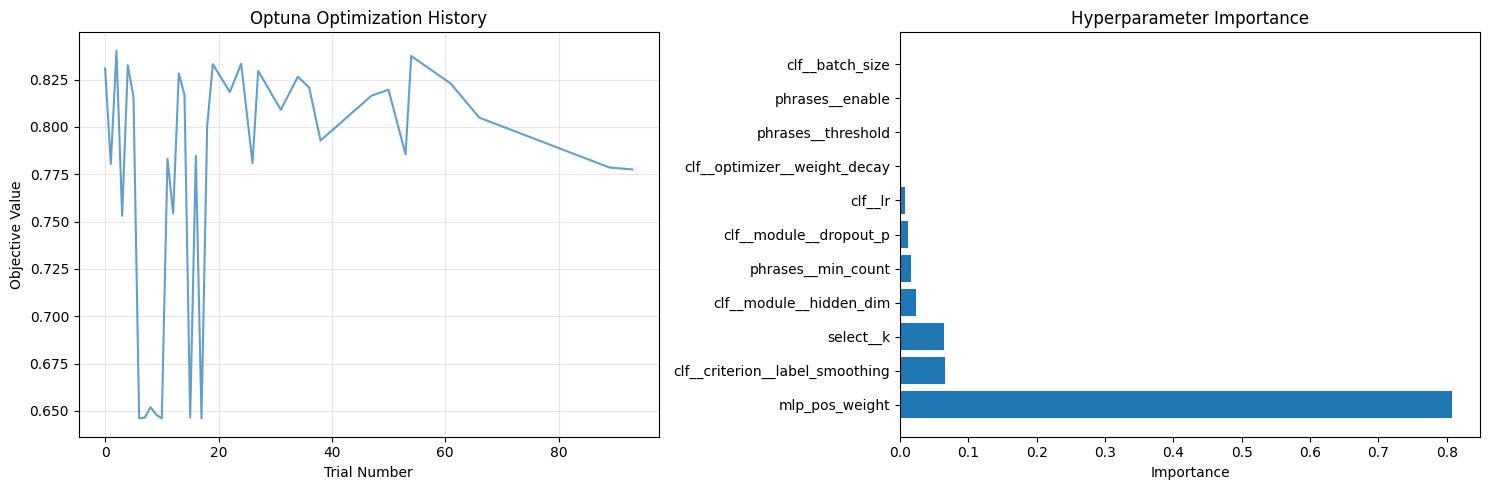


2. Parameter Value Distributions:


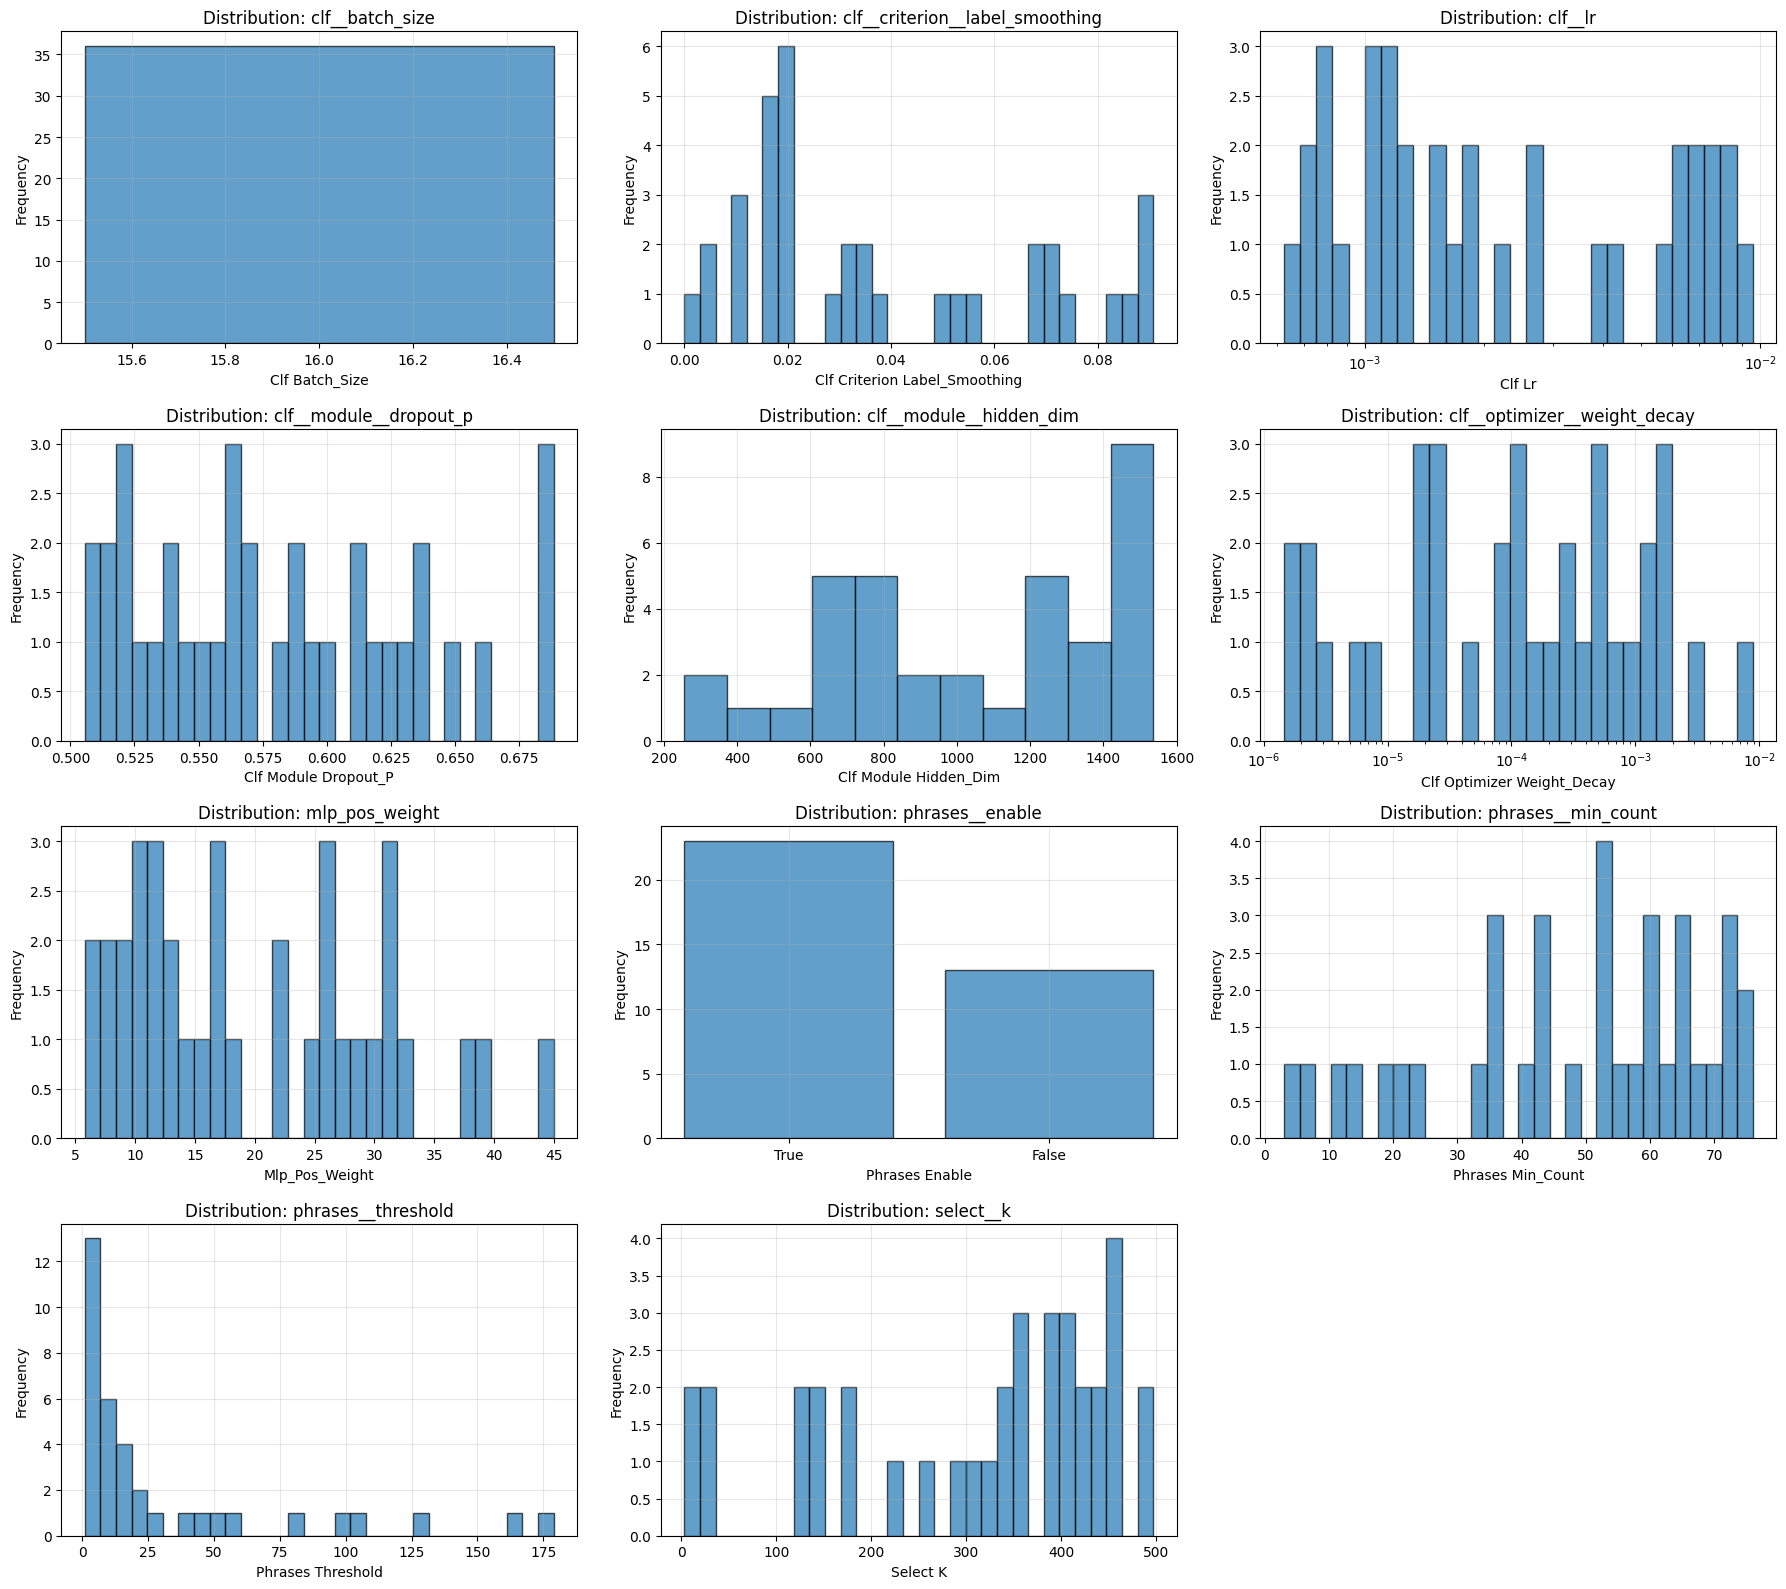


3. Performance vs Individual Parameters:


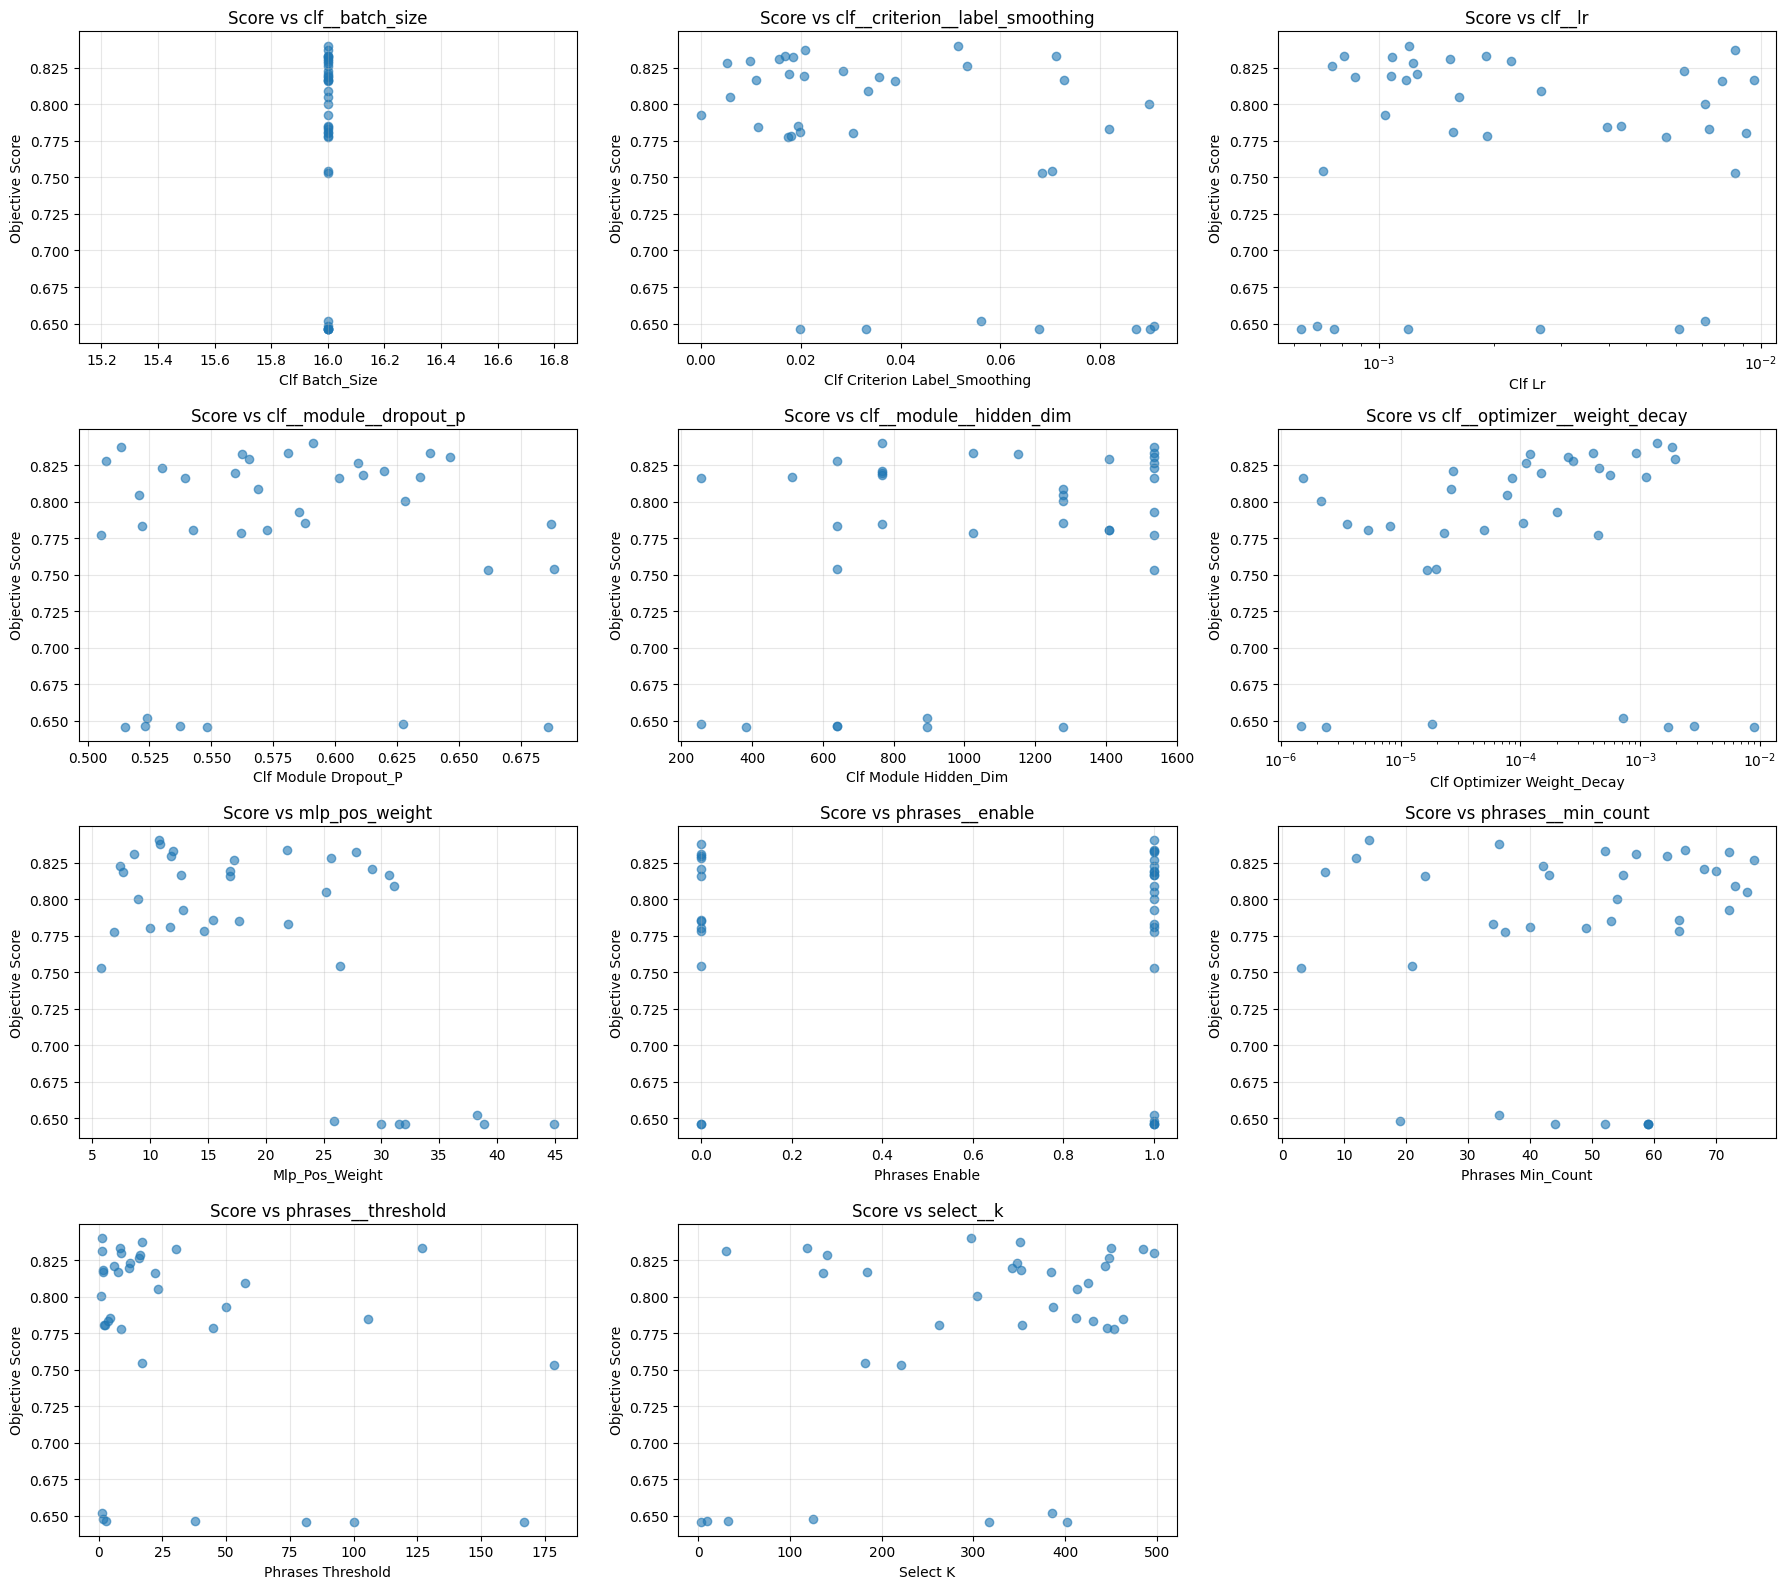


4. Convergence Analysis:


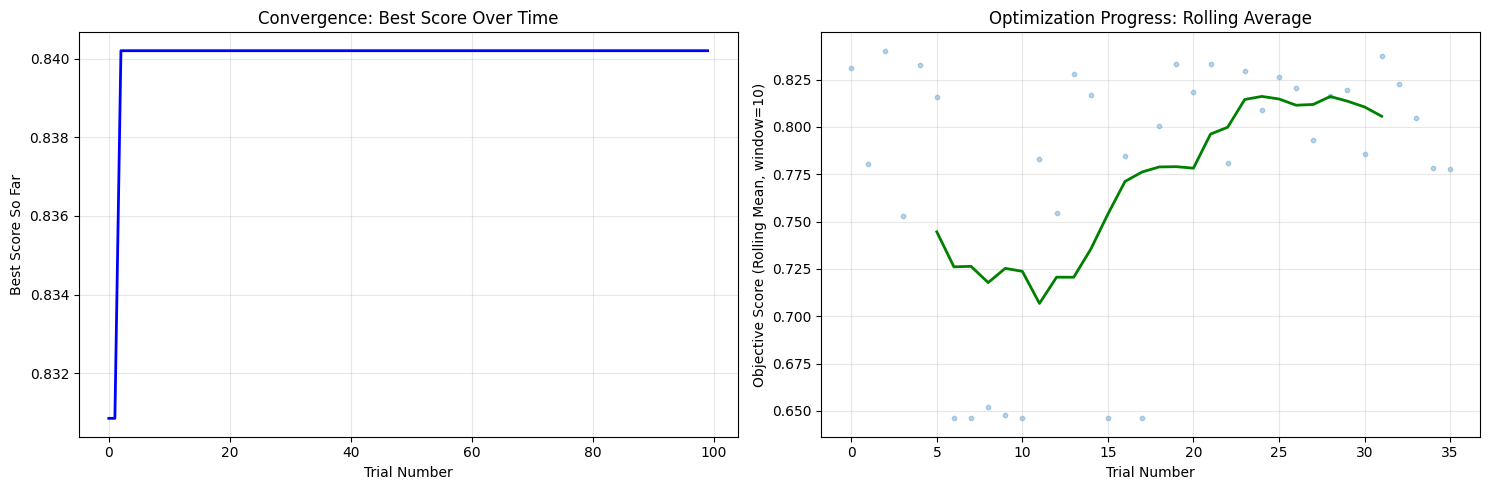


5. Trial Status Overview:


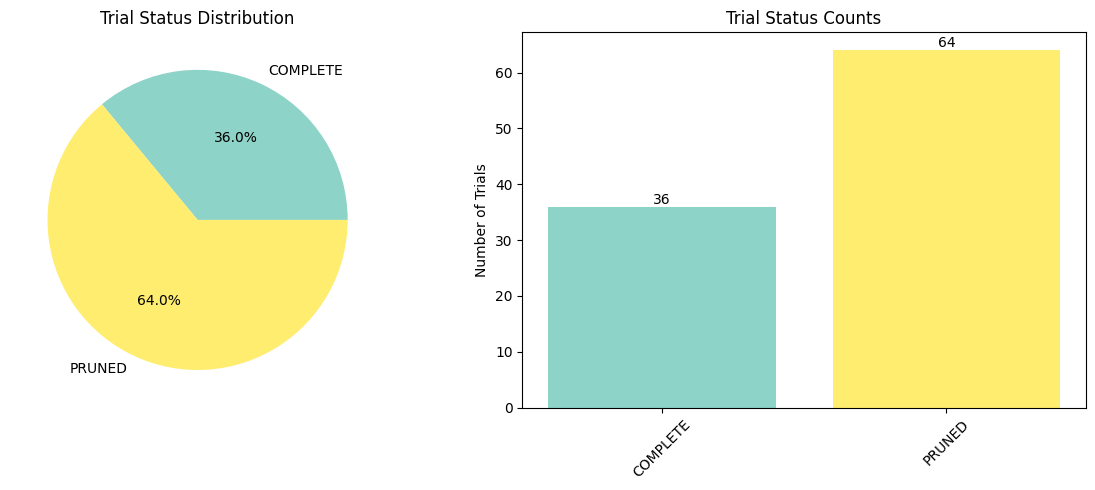


6. Top 10 Best Trials:
Rank Trial#  Score      batch_size   label_smoothing lr           dropout_p    hidden_dim   weight_decay mlp_pos_weight enable       min_count    threshold    k           
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1    2       0.8402     16           0.0514       0.0012       0.5912       768          0.0014       10.7840      True         14           1.4492       297         
2    54      0.8374     16           0.0210       0.0086       0.5137       1536         0.0018       10.8889      False        35           16.8015      351         
3    24      0.8333     16           0.0168       0.0019       0.5809       1536         0.0009       21.8523      True         65           8.4202       450         
4    19      0.8331     16           0.0712       0.0008       0.6384       1024         0.0004       11.9892      True         52 

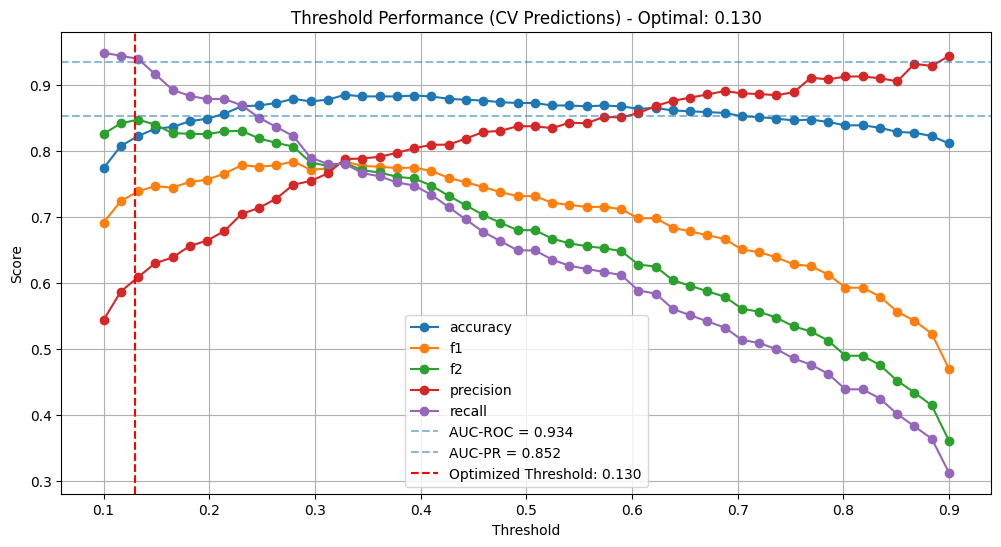

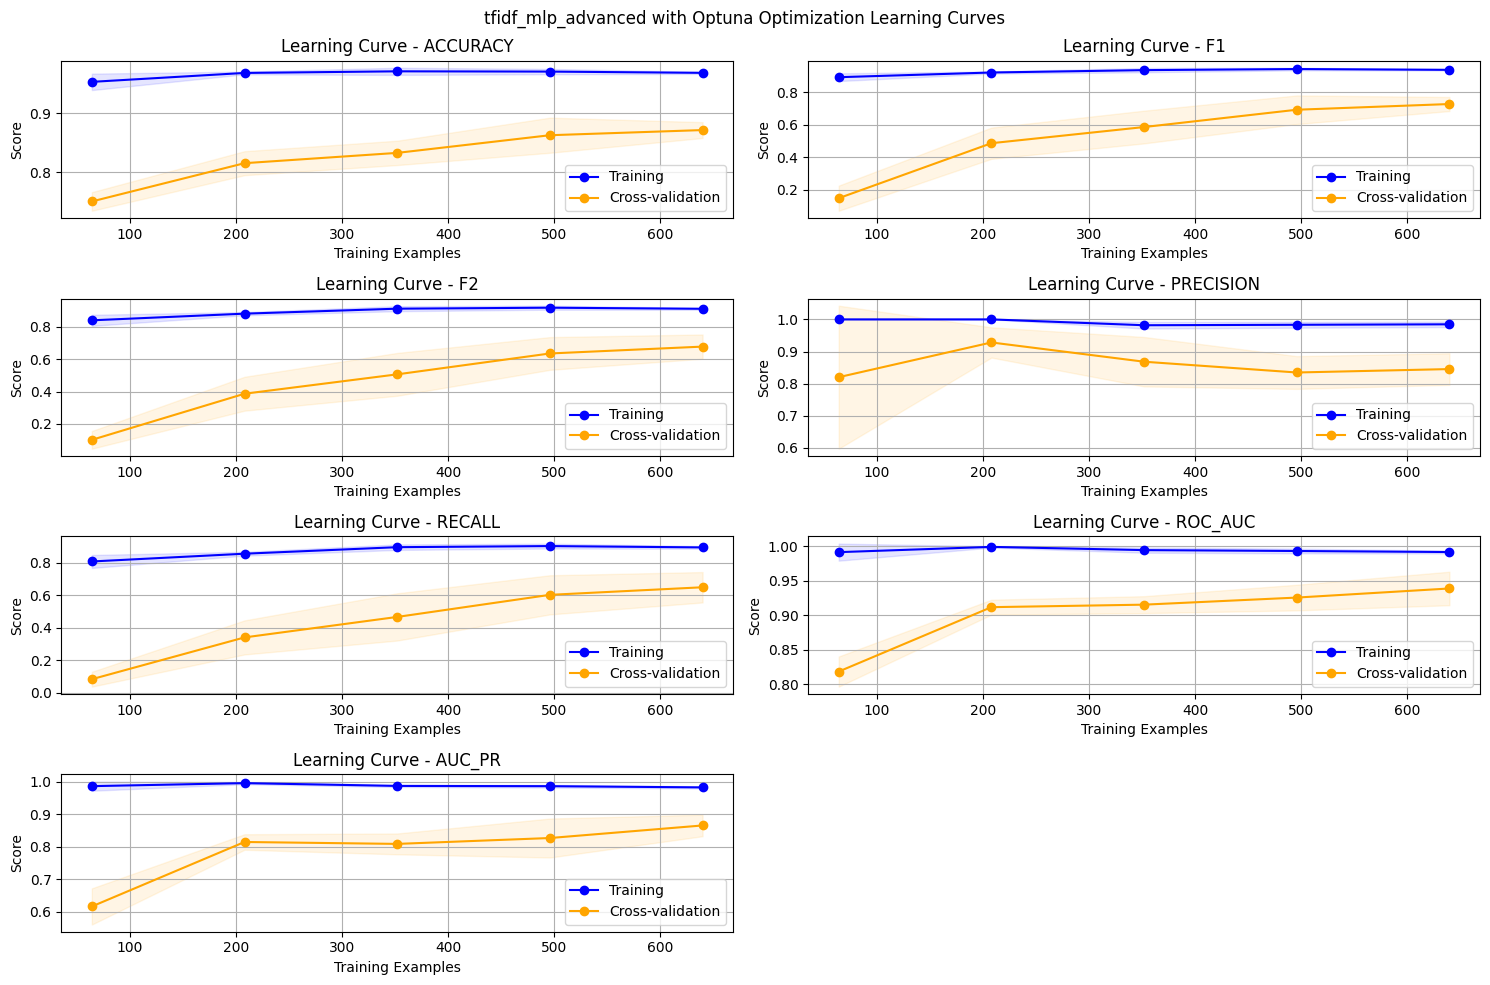


Final Threshold: 0.13
F2-score with default threshold (0.5): 0.625

Test Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82       146
           1       0.54      0.93      0.68        54

    accuracy                           0.77       200
   macro avg       0.75      0.82      0.75       200
weighted avg       0.85      0.77      0.78       200

Additional Metrics:
Accuracy   0.770
F2-score   0.812
AUC-ROC    0.911
AUC-PR     0.786



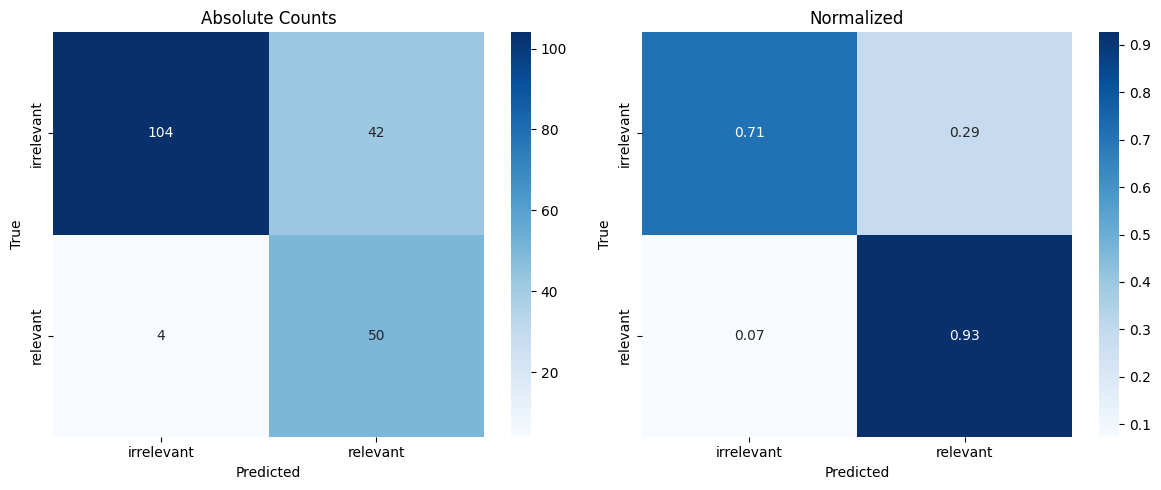

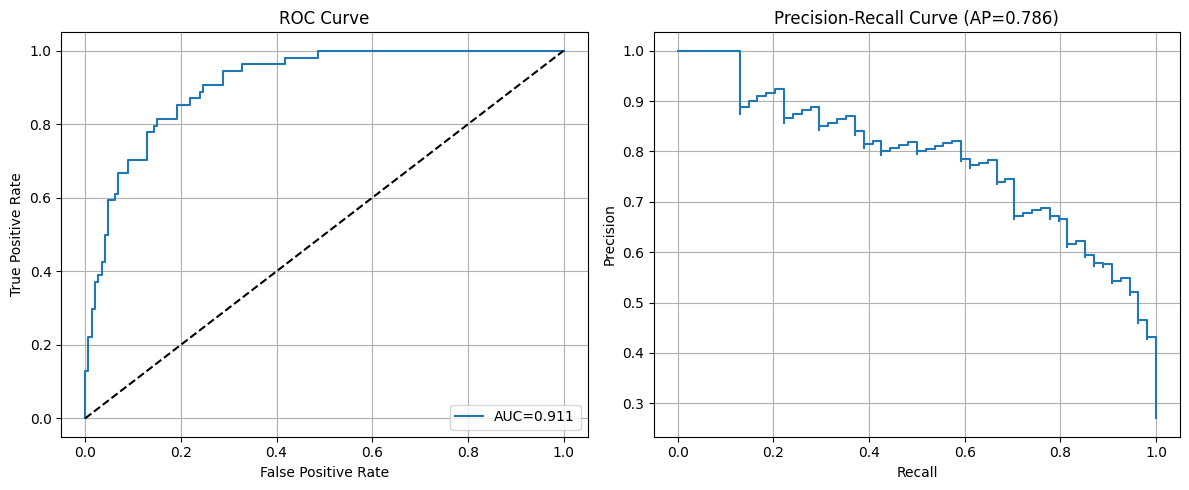


Model saved as model_tfidf_mlp_advanced.joblib


In [9]:
#perform train-test split on advanced cleaned data
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

pipeline_tfidf_mlp = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("to32",    ToFloat32Dense()), #important for dense vectors --> MLP demands them
    ("clf",     make_widemlp_skorch( #defaults as in Galke et al. 2022, optimizer, criterion set in widemlp_skorch.py, optimized by optuna tpe
                max_epochs=100, 
                lr=1e-3, 
                batch_size=16, 
                hidden_dim=1024, 
                dropout_p=0.5,
                random_state=42, 
                force_cuda=True  # use GPU
    )),
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    "clf__lr": lambda t: t.suggest_float("clf__lr", 5e-4, 1e-2, log=True),  # Adam LR around 1e-3 
    "clf__batch_size": lambda t: t.suggest_categorical("clf__batch_size", [16]),  # small batches per paper; 32 as speed option
    "clf__module__hidden_dim": lambda t: t.suggest_int("clf__module__hidden_dim", 256, 1536, step=128),  # structured width search around 1024
    "clf__module__dropout_p": lambda t: t.suggest_float("clf__module__dropout_p", 0.5, 0.7),  # focus around 0.5 as optimum per paper
    "clf__optimizer__weight_decay": lambda t: t.suggest_float("clf__optimizer__weight_decay", 1e-6, 1e-2, log=True),  # tiny L2 for stability
    "clf__criterion__weight": lambda t: torch.tensor([1.0, t.suggest_float("mlp_pos_weight", 1.0, 50.0)], dtype=torch.float32, device="cuda"),  # class weight for positives, force GPU
    "clf__criterion__label_smoothing": lambda t: t.suggest_float("clf__criterion__label_smoothing", 0.0, 0.1), #add some regularization
    "select__k": lambda t: t.suggest_int("select__k", 1, 500),  # chi2 filter filtering features
    "phrases__enable":      lambda t: t.suggest_categorical("phrases__enable", [False, True]),        # 3 Parameters enabled in our advanced (multi word grouping) pipeline.
    "phrases__min_count":   lambda t: t.suggest_int("phrases__min_count", 1, 80),
    "phrases__threshold":   lambda t: t.suggest_float("phrases__threshold", 1.0, 300.0, log=True)
}

model_name = "tfidf_mlp_advanced"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_tfidf_mlp,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "mlp",
    n_trials=100,  # Intelligent search with early stopping
    n_startup_trials=20, # less aggressive prunning
    n_warmup_steps=15,  # first 15 epochs not pruned
    intervall_steps=1, # prunning possible for every epoch
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")





MLP GridSearch advanced

In [ ]:
#perform train-test split on advanced cleaned data
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

pipeline_tfidf_mlp = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("to32",    ToFloat32Dense()), #important for dense vectors --> MLP demands them
    ("clf",     make_widemlp_skorch( #defaults as in Galke et al. 2022, optimizer, criterion set in widemlp_skorch.py, optimized by optuna tpe
                max_epochs=100, 
                lr=1e-3, 
                batch_size=16, 
                hidden_dim=1024, 
                dropout_p=0.5,
                random_state=42, 
                force_cuda=True  # use GPU
    )),
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter grid for gridsearc
#Galke et al. setup with a few variations across chosen parameters based on tpe search

param_grid = {
    "clf__lr": [0.001],                          # fixed Galke et al.
    "clf__module__hidden_dim": [1024],           # fixed Galke et al.
    "clf__module__dropout_p": [0.5],             # fixed Galke et al.
    "clf__optimizer__weight_decay": [0.0014],    # fixed at best (~1.38e-3); slightly stronger L2 helped generalisation
    "clf__batch_size": [16],                     # fixed Galke et al.
    "clf__criterion__label_smoothing": [0.03, 0.05, 0.07],  # small sweep around best (~0.051) to confirm robustness
    "mlp_pos_weight": [10.0, 12.0, 16.0],        # main lever for recall/F2; bracket around best (~10.8) and a tad higher
    "select__k": [300, 350, 450],                # second lever; best near ~297, but several top trials at 348–485 → include higher K
    "phrases__enable": [True],                   # fix to winning setting in best trial to keep grid compact
    "phrases__min_count": [14],                  # fix near best; aggressive phrase discovery matched tpe search
    "phrases__threshold": [1.5],                 # fix near best (~1.45); permissive merging worked well
}


model_name = "tfidf_mlp_advanced"

#for second search with grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_tfidf_mlp,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")